# Projet numérique de science des données - Tallot Louis-Justin et Bellon Judith

## Introduction au projet

Il s'agit dans ce projet d'utiliser des données cartographiques décrivant des carrées de 30m x 30m pour construire un modèle prédictif de l'espèce d'arbre présente sur un tel carré.

Le but final est d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette.

__Consignes :__ 
* Vous devez rendre, par binôme :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms/prénoms__ dans le titre du notebook
* Vous avez jusqu'au __1er juillet midi heure de Paris__
* Déposez vos fichiers [sur Campus](https://campus.mines-paristech.fr/course/view.php?id=404) dans la section dédiée (un seul rendu par binôme est nécessaire)


__Déroulé :__
* Les séances du lundi 14/06 (15h30-17h) et jeudi 24/06 (15h30-17h) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 14/06 ; c'est indiqué le cas échéant.

## Données

### Données publiques et privées

Le dossier `data/` contient deux jeux de données :
* `data/foret_public.tsv` contient les données étiquetées, à partir desquelles construire votre modèle
* `data/foret_prive.tsv` contient les données non-étiquetées, pour lesquelles faire vos prédictions.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* `altitude` : altitude en mètres
* `exposition` : azimut en degrés 
* `pente` : pente en degrés
* `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
* `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
* `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
* `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
* `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
* `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
* `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* `espece` : étiquette : espèce d'arbre présente (0 = pin tordu ; 1 = peuplier)|

### Chargement des données étiquetées

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd

In [187]:
df_public = pd.read_csv('data/foret_public.tsv', delimiter='\t')

In [5]:
df_public.head()

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,espece
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


### Extraction de la matrice de design et des étiquettes 

In [188]:
X_public = np.array(df_public.drop(columns=["espece"]))
y_public = np.array(df_public["espece"])
X_public

array([[2804,  139,    9, ...,  238,  135, 6121],
       [2785,  155,   18, ...,  238,  122, 6211],
       [2579,  132,    6, ...,  237,  140, 6031],
       ...,
       [2932,  323,    7, ...,  233,  170, 2048],
       [2935,  294,    6, ...,  239,  176, 2032],
       [2937,  281,    8, ...,  241,  184, 2017]], dtype=int64)

### Visualisation des variables

#### Question 1
Visualisez chacune des variables de `X_public` sous la forme de deux histogrammes superposés, l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative.

__Conseils :__
* utilisez `pos_indices = np.where(y_public==1)[0]` pour déterminer les indices des lignes de `y_public` (et donc dans `X_public`) dont l'étiquette vaut 1.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

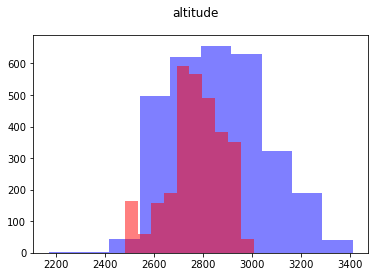

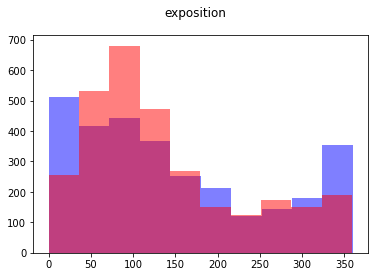

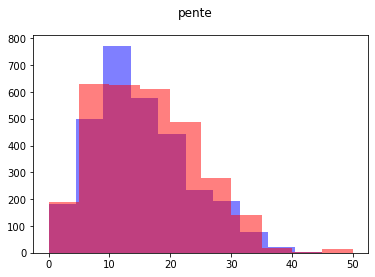

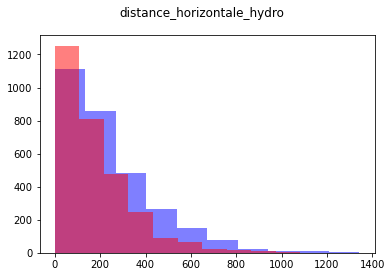

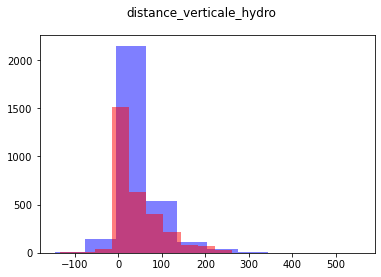

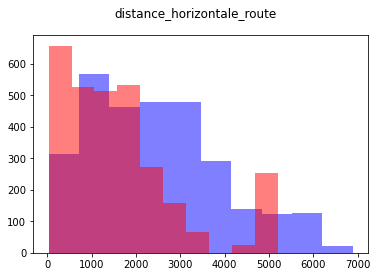

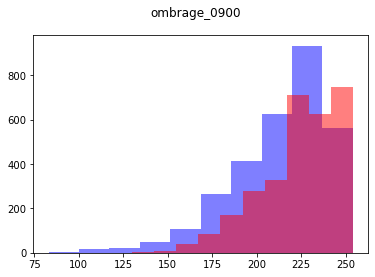

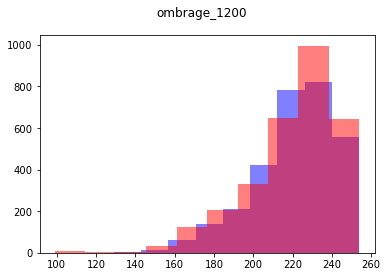

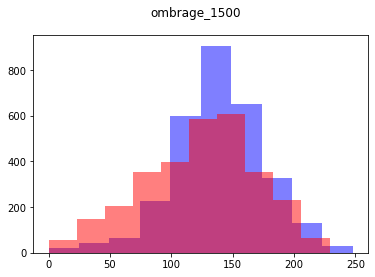

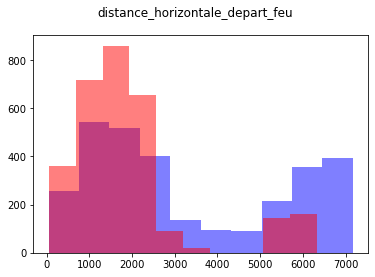

In [7]:
pos_indices_1 = np.where(y_public==1)[0]
pos_indices_0 = np.where(y_public==0)[0]
names = list(df_public.columns)

for i in range(len(X_public[0])):
    plt.figure()
    plt.hist(X_public[pos_indices_0][:,i], alpha=0.5, color='b')
    plt.hist(X_public[pos_indices_1][:,i], alpha=0.5, color='r')
    plt.suptitle(names[i])
    plt.plot()



#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

Les histogrammes bleus (correspondant aux pins tordus) et rouges (peupliers) se ressemblent beaucoup : les plages de valeurs prises sont très comparables, ainsi que les répartitions entre ces valeurs.
Il semble donc a priori difficile de distinguer les deux classes.

### Pré-traitement des variables

#### Question 3
Transformez vos variables d'une manière qui vous parait judicieuse, en vous appuyant notamment sur la PC 3. Vous pouvez essayer différents pré-traitements, mais ce n'est pas nécessaire. Justifiez vos choix. Utilisez un array numpy `X_public_preprocessed` pour enregistrer le résultat.

In [8]:
from sklearn import preprocessing

In [9]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_public)

StandardScaler()

In [10]:
X_public_preprocessed = standard_scaler.transform(X_public)

Nous choisissons de centrer-réduire les variables, afin de normaliser leurs influences respectives sur le résultat.

## Premier modèle : 5-NN

### Algorithme des k plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=5.

#### Question 4

Entraînez un modèle des sur les données `(X_public_preprocessed, y_public)` grâce à la classe `KNeighborsClassifier` du module `neighbors` de `sklearn`, utilisez l'algorithme des 5 plus proches voisins pour entrainer un modèle sur votre jeu d'entraînement.

Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [11]:
from sklearn import neighbors

In [12]:
predictor = neighbors.KNeighborsClassifier(n_neighbors=5)
predictor.fit(X_public_preprocessed, y_public)


KNeighborsClassifier()

### Performance

Il existe de nombreuses métriques pour évaluer les performances d'un algorithme de classification. Nous allons ici utiliser le F-score, dont vous trouverez une description dans la documentation du module `metrics` de `sklearn` : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score et https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics.

#### Question 5
Quel serait sur nos données le F-score d'un modèle naïf prédisant systématiquement la classe positive ?

> Precision (P) is defined as the number of true positives over the number of true positives plus the number of false positives.
Recall (R) is defined as the number of true positives over the number of true positives plus the number of false negatives.
These quantities are also related to the (F1) score, which is defined as the harmonic mean of precision and recall : $F_1 = 2\frac{P \times R}{P+R} $

On pose $nb\_pins = $ `len(pos_indices_0)` et $nb\_peupliers = $ `len(pos_indices_1)`.

Calcul de $P$ : il y a $nb\_pins$ vrais positifs et $nb\_peupliers$ faux positifs.


Donc $P = \dfrac{nb\_peupliers}{nb\_peupliers + nb\_pins}$.

De plus, il n'y a pas de faux positifs : on a donc $R = 1$.

Finalement, $T_1 = 2 \dfrac{P}{P+1} 
= 2 \dfrac{\dfrac{nb\_peupliers}{nb\_peupliers + nb\_pins}}{\dfrac{nb\_peupliers}{nb\_peupliers + nb\_pins}+1}
= \dfrac{2 \; \dfrac{nb\_peupliers}{nb\_peupliers + nb\_pins}}{\dfrac{2 \; nb\_peupliers + nb\_pins}{nb\_peupliers + nb\_pins}}
=\dfrac{2 \; nb\_peupliers}{2 \; nb\_peupliers + nb\_pins}$.

In [13]:
print(f"Le F-score d'un modèle naïf prédisant systématiquement la classe positive "\
f"vaut {2 * len(pos_indices_1) / (2 * len(pos_indices_1) + len(pos_indices_0)):1.2f}.")

Le F-score d'un modèle naïf prédisant systématiquement la classe positive vaut 0.67.


#### Question 6

Quelle est le F-score du modèle de 5 plus proches voisins que vous venez d'entraîner, sur les données `(X_public_preprocessed, y_public)` ?

In [14]:
from sklearn.metrics import f1_score

In [15]:
y_pred = predictor.predict(X_public_preprocessed)

print(f"Le F-score du modèle des plus proches voisins avec k = 5 "\
f"vaut {f1_score(y_public, y_pred):1.2f}.")

Le F-score du modèle des plus proches voisins avec k = 5 vaut 0.93.


#### Question 7
* Que pensez-vous de cette performance ? 
* Est-ce une bonne idée d'évaluer le modèle sur le jeu d'entraînement ? (Réfléchissez en particulier au cas où k=1.)

La performance semble assez bonne. Elle est (heureusement) bien meilleure que si l'on prédit toujours la classe positive.

Ce n'est pas une bonne idée d'évaluer le modèle sur le jeu d'entraînement, cela risque de donner des performances artificiellement élevées. En particulier, si $k=1$, le plus proche voisin d'un élément du jeu d'entrainement est lui-même, le modèle donnera donc toujours la bonne réponse sur le jeu d'entraînement.

In [16]:
# test avec k = 1
predictor_k_1 = neighbors.KNeighborsClassifier(n_neighbors=1)
predictor_k_1.fit(X_public_preprocessed, y_public)

y_pred_k_1 = predictor_k_1.predict(X_public_preprocessed)

print(f"Le F-score du modèle des plus proches voisins avec k = 1 "\
f"vaut {f1_score(y_public, y_pred_k_1):1.2f}.")

Le F-score du modèle des plus proches voisins avec k = 1 vaut 1.00.


## Création d'un jeu de test

À partir de maintenant, nous allons séparer les données en un jeu d'entraînement, que nous utiliserons pour entraîner différents modèles, et un jeu de test, que nous utiliserons pour les comparer. (Cf CM 8).

In [17]:
from sklearn import model_selection

In [129]:
# Use 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_public, y_public, test_size=0.20,
                                                                    stratify=y_public,
                                                                    random_state=42) 
X_train.shape, X_test.shape

((4800, 10), (1200, 10))

In [131]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train)
X_train = standard_scaler.transform(X_train)

In [132]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_test)
X_test = standard_scaler.transform(X_test)

### Performance sur le jeu de test d'un 5-NN entraîné sur le jeu d'entrainement

#### Question 8.a 

Entrainez de nouveau un modèle avec l'algorithme des 5 plus proches voisins, mais cette fois, utilisez uniquement le jeu d'entraînement. __Attention__ à bien « entraîner » votre pre-processing sur le jeu d'entraînement seulement ; considérez le jeu de test comme des données que vous ne voyez pas au moment de l'entraînement.

In [133]:
predictor_train = neighbors.KNeighborsClassifier(n_neighbors=5)
predictor_train.fit(X_train, y_train);

#### Question 8.b
Évaluez le F-score sur le jeu de test du modèle entraîné à la question précédente.

In [134]:
y_pred_train = predictor_train.predict(X_test)

print(f"Le F-score du modèle des plus proches voisins avec k = 5 "\
f"\nentraîné sur {X_train.shape[0]} observations et testé sur {X_test.shape[0]} observations "\
f"vaut {f1_score(y_test, y_pred_train):1.2f}.")

Le F-score du modèle des plus proches voisins avec k = 5 
entraîné sur 4800 observations et testé sur 1200 observations vaut 0.90.


#### Question 9
Commentez le F-score obtenu ci-dessus.

Comme prévu, le F-score obtenu est un peu inférieur au précédent puisque qu'on ne teste plus sur des données ayant servi à entraîner le modèle. 

Cependant, les deux F-scores sont très proches, ce qui semble indiquer qu'avec 5 voisins, l'impact de la réutilisations des données n'est pas si important, il est en quelques sortes "dilué" par les autres voisins. (du moins sur ce jeu de données) 

## [À partir du CM 8 / de la PC 4] Sélection du nombre de plus proches voisins

#### Question 10.a 
Utilisez maintenant une validation croisée pour sélectionner la valeur optimale du nombre de voisins avec `GridSearchCV` (voir notamment PC4). 

Vous pouvez utiliser la grille de valeurs de k suivante, ou la modifier :

In [135]:
k_values = np.arange(3, 32, step=2)

In [136]:
predictor = neighbors.KNeighborsClassifier()
tuned_parameters = [{'n_neighbors': k_values}]

nb_folds = 5
grid = model_selection.GridSearchCV(predictor, tuned_parameters, scoring='f1', cv=nb_folds, refit=False, verbose=3, n_jobs=4)

# run gridsearch
grid.fit(X_train, y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid=[{'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31])}],
             refit=False, scoring='f1', verbose=3)

#### Question 10.b
Quel est le F-score correspondant au nombre de voisins optimal ?

In [137]:
# get F1
scores = grid.cv_results_['mean_test_score']
print(scores)


[0.89626413 0.88745245 0.8814425  0.87361981 0.87044361 0.87048397
 0.86748593 0.86404394 0.86164246 0.8599569  0.85769678 0.85559989
 0.85401388 0.8546014  0.85302401]


#### Question 10.c

Quel est le F-score, sur le jeu de test, d'un modèle obtenu en entraînant un algorithme des k plus proches voisins, avec le k que vous venez de déterminer, sur le jeu d'entraînement ? Commentez.

In [138]:
predictor = neighbors.KNeighborsClassifier(n_neighbors=3)
predictor.fit(X_train, y_train);

y_pred = predictor.predict(X_test)

print(f"Le F-score du modèle des plus proches voisins avec k = 3 "\
f"\nentraîné sur {X_train.shape[0]} observations et testé sur {X_test.shape[0]} observations "\
f"vaut {f1_score(y_test, y_pred):1.2f}.")

Le F-score du modèle des plus proches voisins avec k = 3 
entraîné sur 4800 observations et testé sur 1200 observations vaut 0.90.


## [À partir de la PC 5] Régression logistique

In [ ]:
def plot_gridsearch_results(grid, variable, nb_folds, x_name):
    """Affiche les résultats de la recherche du paramètre optimal
    par validation croisée
    """
    # get F1
    scores = grid.cv_results_['mean_test_score']
    scores_std = grid.cv_results_['std_test_score']
    # compute standard errors
    std_error = scores_std / np.sqrt(nb_folds)

    # initialize plot frame
    plt.figure(figsize=(10, 6))

    # plot scores with a log scale in x-axis
    plt.semilogx(variable, scores, label="Average F_score")
    plt.semilogx(variable, scores + std_error, 'b--')
    plt.semilogx(variable, scores - std_error, 'b--')

    # control the translucency of the fill color with alpha=0.2
    plt.fill_between(variable, scores + std_error, scores - std_error, alpha=0.2)

    # plot best score
    plt.axhline(np.max(scores), linestyle=':', color="firebrick", label="Best F_score")

    # format plot
    plt.xlabel(x_name, fontweight="bold", fontsize=15)
    plt.ylabel("CV score +/- std error", fontweight="bold", fontsize=15)
    plt.xlim([variable[0], variable[-1]])
    plt.title("Gridsearch results (score = F_score)", fontweight="bold", fontsize=20)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

### Régression logistique non-régularisée

#### Question 11.a

Entraînez une régression logistique non-régularisée sur le jeu d'entraînement.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `LogisticRegression` du module `linear_model` de `scikit-learn` ; il s'agit ainsi d'une variante de la PC5. Comme toujours, référez-vous à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
* Pour ne pas avoir de régularisation, utilisez `penalty='none'`

In [140]:
from sklearn.linear_model import LogisticRegression

In [141]:
predictor = LogisticRegression(penalty='none', max_iter=1000)
predictor.fit(X_train, y_train);

#### Question 11.b
Évaluez le F-score de cette régression logistique non-régularisée sur le jeu de test.

In [142]:
y_pred = predictor.predict(X_test)

print(f"Le F-score de la régression logistique non-régularisée "\
f"vaut {f1_score(y_test, y_pred):1.4f}.")

Le F-score de la régression logistique non-régularisée vaut 0.7770.


#### Question 12
Vous attendez-vous à ce qu'utiliser une régularisation l2 améliore les performances du modèle ? Pourquoi ?

Oui, car elle limiterait le surapprentissage. 

#### Question 13.a
Déterminez par validation croisée une valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.

In [143]:
alphas = np.logspace(-4, 4, 30)
predictor = LogisticRegression(penalty='l2', max_iter=1000)
tuned_parameters = [{'C': alphas}]

nb_folds = 5

grid = model_selection.GridSearchCV(predictor, tuned_parameters, scoring='f1', cv=nb_folds, refit=False, verbose=3, n_jobs=6)
# run gridsearch
grid.fit(X_train, y_train)



Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=6,
             param_grid=[{'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04])}],
             refit=False, scoring='f1', verbose=3)

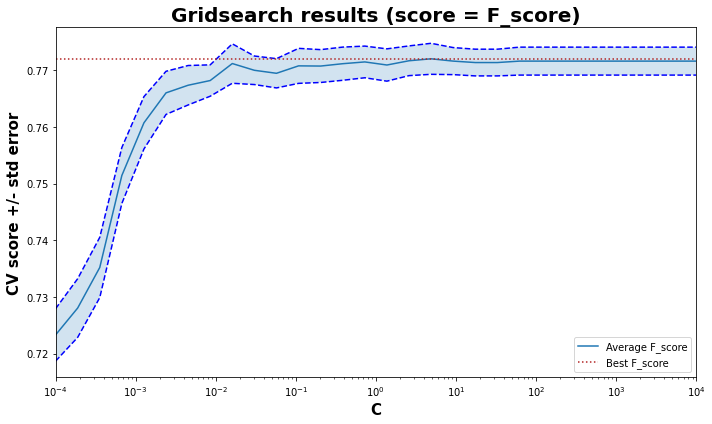

In [146]:
plot_gridsearch_results(grid, alphas, nb_folds, "C")

#### Question 13.b
Quel est le F-score, sur le jeu de test, d'une régression logistique avec régularisation ridge et ce coefficient de régularisation optimal, entraînée sur le jeu d'entraînement ?

In [114]:
predictor = LogisticRegression(penalty='l2', C=3, max_iter=1000)
predictor.fit(X_train, y_train);

y_pred = predictor.predict(X_test)

print(f"Le F-score de la régression logistique régularisée "\
f"vaut {f1_score(y_test, y_pred):1.4f}.")

Le F-score de la régression logistique régularisée vaut 0.7747.


#### Question 13.c
Commentez ce résultat en regard de votre réponse à la question 12.

Finalement ça n'améliore pas beaucoup.

#### Question 14

Entraînez une forêt aléatoire sur le jeu d'entraînement et évaluez son F-score sur le jeu de test.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `RandomForestClassifier` du module `ensemble` de `scikit-learn`.
* Choisissez le nombre d'arbres par validation croisée.

In [115]:
from sklearn.ensemble import RandomForestClassifier

In [180]:
n_trees = np.logspace(1.4, 3.5, 20).astype(int)
predictor_forest = RandomForestClassifier(random_state=0)
tuned_parameters = [{'n_estimators': n_trees}]

nb_folds = 5
grid = model_selection.GridSearchCV(predictor_forest, tuned_parameters, scoring='f1', cv=nb_folds, refit=False, verbose=3, n_jobs=10)

# run gridsearch
grid.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=10,
             param_grid=[{'n_estimators': array([  25,   31,   39,   50,   63,   79,  100,  125,  158,  199,  251,
        316,  398,  501,  630,  794, 1000, 1258, 1584, 1995])}],
             refit=False, scoring='f1', verbose=3)

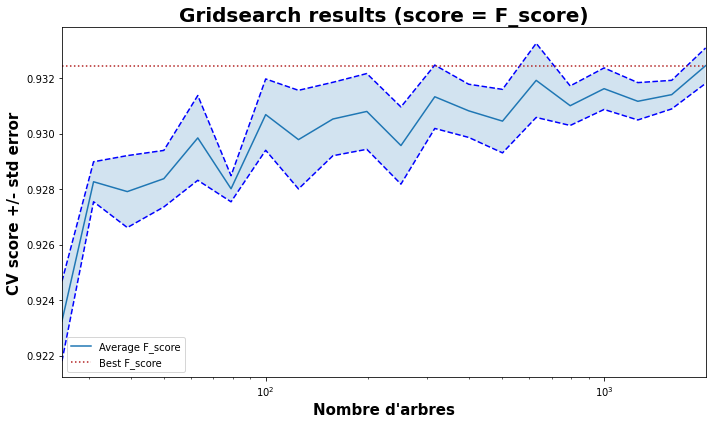

In [181]:
plot_gridsearch_results(grid, n_trees, nb_folds, "Nombre d'arbres")

In [175]:
predictor_forest = RandomForestClassifier(n_estimators=1050, random_state=0)
predictor_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1050, random_state=0)

In [176]:
y_pred = predictor_forest.predict(X_test)

print(f"Le F-score de la forêt aléatoire "\
f"vaut {f1_score(y_test, y_pred):1.4f}.")

Le F-score de la forêt aléatoire vaut 0.9451.


## Modèle final

#### Question 15.a
Visualisez les performances des différents modèles (et pré-traitements) que vous avez évalués sur le jeu de test.

In [120]:
# la liste contenant nos modèles
liste_predictors = [
    neighbors.KNeighborsClassifier(n_neighbors=3),
    LogisticRegression(penalty='l2', C=3, max_iter=1000),
    RandomForestClassifier(n_estimators=600),
]

In [121]:
# on entraîne nos modèles sur nos données d'entraînement
liste_predictors = [predictor.fit(X_train, y_train) for predictor in liste_predictors]

In [122]:
# on applique les modèles aux données de test
liste_y_pred = [predictor.predict(X_test) for predictor in liste_predictors]

In [123]:
# on calcule le f-score de nos modèles
liste_f1_score = [f1_score(y_test, y_pred) for y_pred in liste_y_pred]

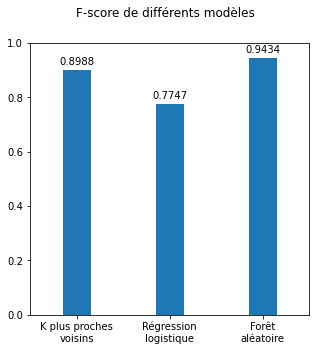

In [124]:
plt.figure(figsize=(5, 5))

plt.ylim(0,1)
plt.xlim(-0.5,2.5)
plt.bar(["K plus proches\nvoisins", "Régression\nlogistique", "Forêt\naléatoire"], 
        liste_f1_score,
        width=0.3,
)
for x in [0, 1, 2]:
    plt.gca().text(x, 1.015*liste_f1_score[x],
                '%1.4f' % (liste_f1_score[x]),
                ha='center', va='bottom')

plt.suptitle("F-score de différents modèles");

#### Question 15.b
Utilisez cette figure pour __sélectionner votre modèle favori__. Quel pré-traitement choisissez-vous ? Quel algorithme choisissez-vous, avec quel hyper-paramètre ? 

Nous choisissons le modèle avec le meilleur F-score, qui est ici la forêt aléatoire avec 600 arbres. Nous utilisons les données centrées-réduites.

#### Question 16.a
Chargez les données privées de `data/foret_prive.tsv` pour obtenir un array `X_private`. Le fichier suit la même syntaxe que `data/foret_public.tsv`, mais sans la colonne des étiquettes.

In [189]:
df_private = pd.read_csv('data/foret_prive.tsv', delimiter='\t')

In [190]:
df_private.head()

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu
0,2654,42,15,60,7,1862,221,206,116,6907
1,2649,24,13,30,2,1832,213,211,133,6889
2,2647,357,16,0,0,1802,194,210,152,6870
3,2650,5,19,0,0,1772,192,199,141,6852
4,2645,25,24,30,7,1742,201,182,108,6834


In [191]:
X_private = np.array(df_private)

#### Question 16.b
Appliquez le pré-traitement que vous avez choisi à l'intégralité du jeu de données public `X_public` pour obtenir `X_public_preprocessed`.

In [192]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_public)
X_public_preprocessed = standard_scaler.transform(X_public)

#### Question 16.c
Appliquez à `X_private` le pré-traitement que vous avez choisi ; enregistrez le résultat dans `X_private_preprocessed`.

In [193]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_private)
X_private_preprocessed = standard_scaler.transform(X_private)

#### Question 16.d
Entraînez l'algorithme que vous avez sélectionné sur l'intégralité des données publiques `(X_public_processed, y_public)`. 

In [194]:
predictor_final = RandomForestClassifier(n_estimators=1050, random_state=0)
predictor_final.fit(X_public_preprocessed, y_public)

RandomForestClassifier(n_estimators=1050, random_state=0)

#### Question 16.e
Prédisez les étiquettes de `X_private_preprocessed` ; enregistrez le résultat dans un array `y_pred_final`

In [197]:
y_pred_final = predictor_final.predict(X_private_preprocessed)

#### Question 16.f
Utilisez le code suivant pour créer le fichier de prédictions que vous rendrez. 

__Attention__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser une commande bash type `less` ou `cat` ou éditeur de texte simple ; ou alors assurez-vous de relancer la commande.

In [200]:
# Save array to file
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

## Bonus

1. En alternative au F-score, utilisez des courbes ROC (et l'aire sous ces courbes) pour comparer vos modèles. Attention à utiliser les méthodes `predict_proba()` plutôt que `predict()` pour obtenir des scores non-seuillés plutôt que des prédictions binaires. Documentation pertinente : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html et  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.

1. Explorez d'autres pré-traitements (comme par exemple le fait de réduire la dimension des données) et d'autres algorithmes d'apprentissage implémentés dans scikit-learn (par exemple SVM, perceptrons multi-couches) pour essayer d'améliorer vos prédictions et reprenez la question 15.